# Test EC-CA3 heterosynaptic plasticity

Here we test the plasticity mechanism in our LIFNtwk class by ensuring that when we use physiological parameters (as specified in [parameters.ipynb](parameters.ipynb)) low rate spiking output in our CA3 cells yield no synaptic weight change in the EC-CA3 weights but tetanic spiking outputs yield very strong weight changes.

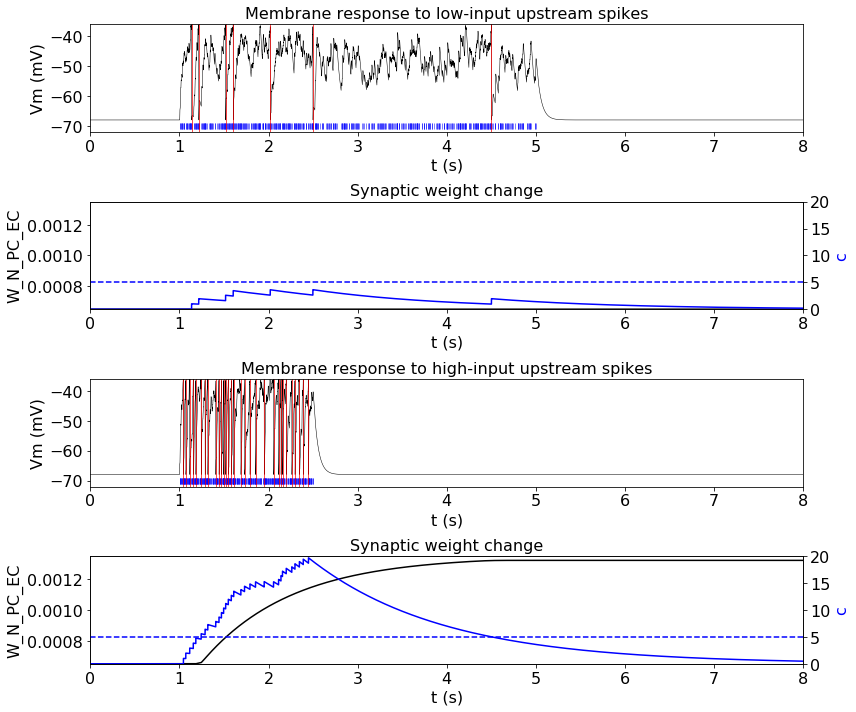

In [1]:
%reset -f
%matplotlib inline
import pdb
import matplotlib.pyplot as plt
import numpy as np

from ntwk import LIFNtwk
import plot

import PARAMETERS as P

R_PL_LOW = 150
R_PL_HIGH = 350

DUR = 8
SPKS_UP_LOW_START = 1
SPKS_UP_LOW_END = 5
SPKS_UP_HIGH_START = 1
SPKS_UP_HIGH_END = 2.5


np.random.seed(0)

# generate upstream input spike trains to feed through AMPA weights
# (we assume inp 0 is AMPA 0, inp 2 is NMDA, inp 3 is AMPA 1)
ts = np.arange(0, DUR, P.DT)
spks_up = np.zeros((len(ts), 3))

# provide low rate to first PC (inp 0)
spks_up_low_mask = (ts >= SPKS_UP_LOW_START) & (ts < SPKS_UP_LOW_END)
spks_up[spks_up_low_mask, 0] = np.random.poisson(R_PL_LOW*P.DT, spks_up_low_mask.sum())

# provide high rate to second PC (inp 2)
spks_up_high_mask = (ts >= SPKS_UP_HIGH_START) & (ts < SPKS_UP_HIGH_END)
spks_up[spks_up_high_mask, 2] = np.random.poisson(R_PL_HIGH*P.DT, spks_up_high_mask.sum())

# make synaptic weight matrices
ws_rcr = {
    'AMPA': np.zeros((2, 2)),
    'NMDA': np.zeros((2, 2)),
}
ws_up = {
    'AMPA': np.array([[P.W_A_PC_PL, 0, 0], [0, 0, P.W_A_PC_PL]]),
    'NMDA': np.array([[0, P.W_N_PC_EC_I, 0], [0, P.W_N_PC_EC_I, 0]]),
}

# make masks for plastic weights
masks = {
    'AMPA': np.zeros((2, 3), dtype=bool),
    'NMDA': np.array([[False, True, False], [False, True, False]]),
}

# make plasticity dict
plasticity = {
    'masks': masks,
    'w_ec_ca3_maxs': {'AMPA': np.nan, 'NMDA': P.W_N_PC_EC_F},
    'T_W': P.T_W,
    'T_C': P.T_C,
    'C_S': P.C_S,
    'BETA_C': P.B_C,
}

# make ntwk
ES_SYN = {'AMPA': P.E_A, 'NMDA': P.E_N}
TS_SYN = {'AMPA': P.T_A, 'NMDA': P.T_A}

ntwk = LIFNtwk(
    t_m=np.repeat(P.T_M_PC, 2),
    e_l=np.repeat(P.E_L_PC, 2),
    v_th=np.repeat(P.V_TH_PC, 2),
    v_reset=np.repeat(P.V_RESET_PC, 2),
    t_r=np.repeat(0.002, 2),
    es_syn=ES_SYN, ts_syn=TS_SYN, ws_rcr=ws_rcr, ws_up=ws_up,
    plasticity=plasticity)

# run simulation with low and high upstream spiking rates
vs_0 = P.E_L_PC * np.ones(2)
gs_0 = {'AMPA': np.zeros(2), 'NMDA': np.zeros(2)}

resp = ntwk.run(spks_up, P.DT, vs_0, gs_0)

# plot voltage and spiking responses and plastic synaptic weight time-series
fig, axs = plt.subplots(4, 1, figsize=(12, 10), tight_layout=True)
axs_twin = []

# low-input voltage
axs[0].plot(ts, 1000 * resp.vs[:, 0], color='k', lw=0.5)

# low-input upstream spikes
spk_ts_up_low = spks_up[:, 0].nonzero()[0] * P.DT
axs[0].scatter(spk_ts_up_low, -70*np.ones(spk_ts_up_low.shape), marker='|', c='b', lw=0.5)

# low-input output spikes
for t_spk_out in resp.spks[:, 0].nonzero()[0] * P.DT:
    axs[0].axvline(t_spk_out, color='r', lw=0.7)

axs[0].set_xlim(ts[0], ts[-1])
axs[0].set_ylim(-72, 1000 * P.V_TH_PC)
axs[0].set_xlabel('t (s)')
axs[0].set_ylabel('Vm (mV)')
axs[0].set_title('Membrane response to low-input upstream spikes')

# low-input synaptic weight time-series
axs[1].plot(ts, resp.ws_plastic['NMDA'][:, 0], color='k')

axs[1].set_xlim(ts[0], ts[-1])
axs[1].set_ylim(P.W_N_PC_EC_I, P.W_N_PC_EC_F)

axs[1].set_xlabel('t (s)')
axs[1].set_ylabel('W_N_PC_EC')
axs[1].set_title('Synaptic weight change')

# spk-ctr auxiliary variable
axs_twin.append(axs[1].twinx())
axs_twin[0].plot(ts, resp.cs[:, 0], color='b')
axs_twin[0].axhline(P.C_S, color='b', ls='--')
axs_twin[0].set_ylim(0, 4*P.C_S)
axs_twin[0].set_ylabel('c', color='b')

# high-input voltage
axs[2].plot(ts, 1000 * resp.vs[:, 1], color='k', lw=0.5)

# high-input upstream spikes
spk_ts_up_high = spks_up[:, 2].nonzero()[0] * P.DT
axs[2].scatter(spk_ts_up_high, -70*np.ones(spk_ts_up_high.shape), marker='|', c='b', lw=0.5)

# high-input output spikes
for t_spk_out in resp.spks[:, 1].nonzero()[0] * P.DT:
    axs[2].axvline(t_spk_out, color='r', lw=0.7)
    
axs[2].set_xlim(ts[0], ts[-1])
axs[2].set_ylim(-72, 1000 * P.V_TH_PC)
axs[2].set_xlabel('t (s)')
axs[2].set_ylabel('Vm (mV)')
axs[2].set_title('Membrane response to high-input upstream spikes')

# high-input synaptic weight time-series
axs[3].plot(ts, resp.ws_plastic['NMDA'][:, 1], color='k')

axs[3].set_xlim(ts[0], ts[-1])
axs[3].set_ylim(P.W_N_PC_EC_I, P.W_N_PC_EC_F)

axs[3].set_xlabel('t (s)')
axs[3].set_ylabel('W_N_PC_EC')
axs[3].set_title('Synaptic weight change')

# spk-ctr auxiliary variable
axs_twin.append(axs[3].twinx())
axs_twin[1].plot(ts, resp.cs[:, 1], color='b')
axs_twin[1].axhline(P.C_S, color='b', ls='--')
axs_twin[1].set_ylim(0, 4*P.C_S)
axs_twin[1].set_ylabel('c', color='b')

for ax in list(axs) + axs_twin:
    plot.set_font_size(ax, 16)
    
# make sure no AMPA weights but both NMDA weights have been updated
assert resp.ws_plastic['AMPA'].shape == (len(ts), 0)
assert resp.ws_plastic['NMDA'].shape == (len(ts), 2)